# 📦 Amazon Reviews Clustering Project

## 🎯 Cel biznesowy
Celem projektu jest eksploracja recenzji klientów Amazon na poziomie tekstu i wyodrębnienie naturalnych grup recenzji za pomocą metod klasteryzacji. Dzięki temu możliwe będzie uzyskanie dodatkowego wglądu w strukturę opinii użytkowników — bez konieczności wcześniejszego nadawania etykiet.

## 🗂 Dane wejściowe
Zbiór danych zawiera recenzje produktów pochodzące z platformy Amazon. Składają się one z oryginalnego tekstu recenzji, a także dodatkowych cech takich jak ocena liczbowa, klasyfikacja sentymentu czy rozkład emocji (tych na razie nie używamy — skupiamy się wyłącznie na surowym tekście z kolumny `Text`).

## ⚙️ Cel klasteryzacji
- Identyfikacja głównych grup tematycznych i tonów wypowiedzi klientów
- Zrozumienie, jak różne typy recenzji są ze sobą powiązane semantycznie
- Odkrycie nieoczywistych wzorców, np. ukrytych tematów, form językowych lub emocjonalnych tonów

## 💡 Potencjalne zastosowania
- Automatyczne przypisywanie recenzji do zespołów obsługi klienta w zależności od ich tonu lub tematyki
- Analiza niezadowolenia klientów bez potrzeby nadzorowanego etykietowania
- Wykrywanie recenzji o wysokim wpływie (np. negatywnych z konkretną argumentacją)
- Zasilenie dashboardów analitycznych segmentacją treści


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
df = pd.read_csv("data/cleaned_amazon_reviews.csv")

df=df[["Text"]]

df.head()

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...


In [4]:
df["Text"].isna().sum()

0

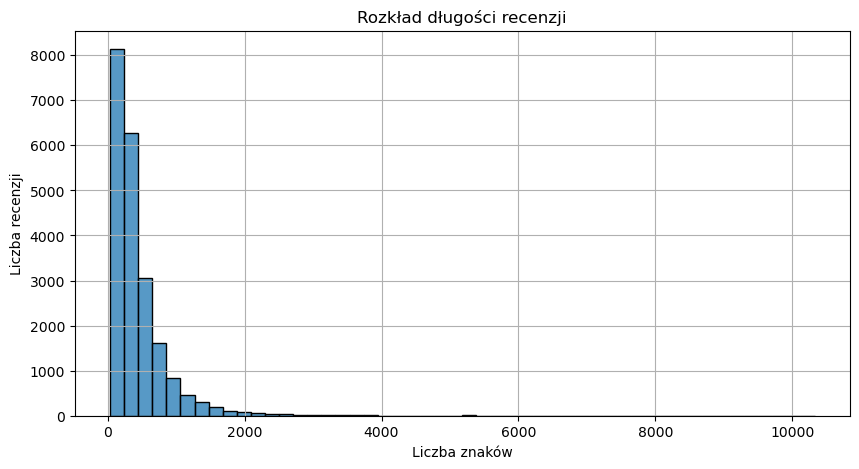

In [5]:
df["length"]=df["Text"].str.len()

plt.figure(figsize=(10,5))
sns.histplot(df["length"],bins=50,kde=False)
plt.title("Rozkład długości recenzji")
plt.xlabel("Liczba znaków")
plt.ylabel("Liczba recenzji")
plt.grid(True)
plt.show()

## 🧠 Analiza złożoności tekstu

W tej sekcji obliczamy podstawowe wskaźniki złożoności językowej dla każdej recenzji. Metryki takie jak liczba słów, długość słów, liczba unikalnych słów czy średnia długość zdania pozwalają ocenić, jak rozbudowane i wymagające językowo są opinie użytkowników. 

Metryki zdaniowe (np. liczba zdań, średnia liczba słów w zdaniu) zostały wyliczone na podstawie oryginalnej wersji tekstu (`Text`), natomiast metryki słowne na podstawie oczyszczonego tekstu (`clean_text`).

In [18]:
import pandas as pd
import re

def analyze_text_complexity(row):
    clean_text = row['clean_text']
    raw_text = row['Text']
    
    words = clean_text.split()
    num_words = len(words)
    text_len = len(clean_text)
    
    avg_word_length = sum(len(word) for word in words) / num_words if num_words > 0 else 0
    unique_words = len(set(words))

    sentences = re.split(r'[.!?]+', raw_text)
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    num_sentences = len(sentences)
    avg_words_per_sentence = sum(len(s.split()) for s in sentences) / num_sentences if num_sentences > 0 else 0

    return pd.Series({
        'num_words': num_words,
        'avg_word_length': avg_word_length,
        'num_unique_words': unique_words,
        'text_length': text_len,
        'num_sentences': num_sentences,
        'avg_words_per_sentence': avg_words_per_sentence,
    })

complexity_features = df.apply(analyze_text_complexity, axis=1)


complexity_features[[
    'num_words', 'avg_word_length',
    'num_unique_words', 'text_length', 'num_sentences',
    'avg_words_per_sentence'
]].sample(5)

mean_values = complexity_features.mean().round(2)

print("Średnie wartości wskaźników złożoności tekstu:\n")
print(mean_values.sort_values(ascending=False))

Średnie wartości wskaźników złożoności tekstu:

text_length               413.01
num_words                  78.71
num_unique_words           55.10
avg_words_per_sentence     13.83
num_sentences               5.83
avg_word_length             4.24
dtype: float64


### Wstępne czyszczenie tekstu

Usuwamy znaki specjalne, liczby oraz zamieniamy tekst na małe litery, aby ujednolicić dane i zmniejszyć szum językowy przed dalszym przetwarzaniem.

In [6]:
def clean_text(text):
    text=text.lower()

    text = re.sub(r"\s+", " ", text).strip()

    text = re.sub(r"[^a-z\s]", "", text)

    return text


df["clean_text"]=df["Text"].apply(clean_text)

df[["Text","clean_text"]].sample(5)


,Text,clean_text
6889,I'm a big fan of avoiding corn syrup and a lot...,im a big fan of avoiding corn syrup and a lot ...
10081,I stumbled onto these and decided to give them...,i stumbled onto these and decided to give them...
2197,I have two recipes I'm anxious to try that cal...,i have two recipes im anxious to try that call...
13892,but be aware. It is addictive. I love this s...,but be aware it is addictive i love this stuff...
10177,This hot chocolate is pretty blah. Not very ch...,this hot chocolate is pretty blah not very cho...


### Detekcja języka

Sprawdzamy, w jakim języku są napisane recenzje, i zachowujemy tylko te, które są w języku angielskim.


In [7]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "error"

df['lang'] = df['clean_text'].apply(detect_language)

print(df['lang'].value_counts())

lang
en    21246
es        5
cy        1
sq        1
et        1
fr        1
Name: count, dtype: int64


In [8]:
df=df[df["lang"]=="en"].reset_index(drop=True)

print(df['lang'].value_counts())

lang
en    21246
Name: count, dtype: int64


## 🔤 Tokenizacja i lematyzacja tekstu

Na tym etapie dokonujemy tokenizacji i lematyzacji tekstów z kolumny `clean_text`. 
Za pomocą biblioteki spaCy identyfikujemy pojedyncze słowa (tokeny), usuwamy stop words oraz pomijamy tokeny krótsze niż 3 znaki. Każdy token zamieniany jest na swoją formę podstawową (lemat), co pozwala uprościć analizę i zmniejszyć różnorodność słów o tym samym znaczeniu.

In [9]:
import spacy

# Załaduj angielski model językowy
nlp = spacy.load("en_core_web_sm")

def spacy_preprocess(text):
    doc = nlp(text)
    tokens = []
    
    for token in doc:
        if not token.is_stop and len(token.text) > 2:
            lemma=token.lemma_
            tokens.append(lemma)

    return tokens

# Stosujemy funkcję do oczyszczonych tekstów
df['tokens'] = df['clean_text'].apply(spacy_preprocess)

# Podgląd
df[['Text', 'tokens']].sample(5)


,Text,tokens
1537,Provided you use clean (preferably purified) w...,"[provide, use, clean, preferably, purify, wate..."
16668,This product is great. I thought I would neve...,"[product, great, think, able, eatbr, great, ta..."
7310,I've used Natures Logic Dog Food for about a y...,"[nature, logic, dog, food, year, difference, d..."
19376,"I like ""regular"" Oreo cookies. I could just a...","[like, regular, oreo, cookie, eat, entire, bag..."
20769,I am sad to say that my dogs are completely ad...,"[sad, dog, completely, addicted, greenie, nigh..."


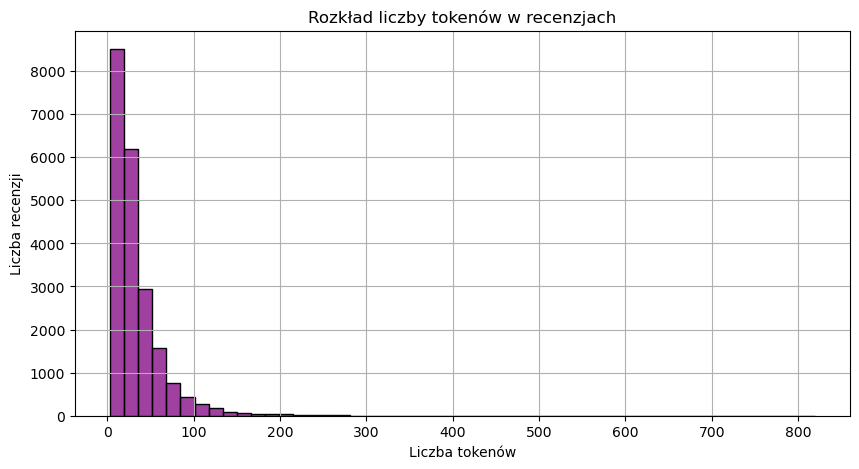

In [10]:
df['num_tokens'] = df['tokens'].apply(len)

# Wykres
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['num_tokens'], bins=50, color='purple')
plt.title("Rozkład liczby tokenów w recenzjach")
plt.xlabel("Liczba tokenów")
plt.ylabel("Liczba recenzji")
plt.grid(True)
plt.show()

## 📊 Najczęściej występujące słowa

Poniżej prezentujemy 20 najczęściej pojawiających się słów w zlematyzowanych recenzjach klientów. Analiza częstości pomaga nam zrozumieć, które pojęcia dominują w opinii użytkowników – czy są to emocje, cechy produktów, czy może ogólne zwroty.

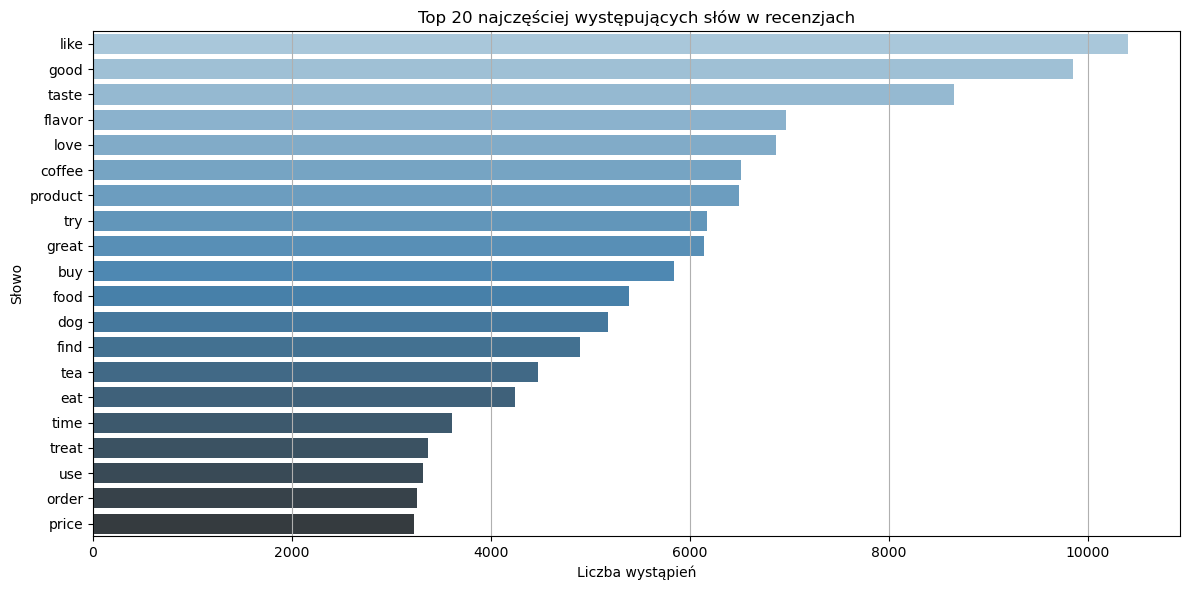

In [22]:
from collections import Counter 

word_counts_dict={}

for token_lsit in df["tokens"]:
    for word in token_lsit:
        if word in word_counts_dict:
            word_counts_dict[word]+=1
        else:
            word_counts_dict[word]=1

sorted_counts=sorted(word_counts_dict.items(), key=lambda x: x[1],reverse=True)[:20]

top_words_df = pd.DataFrame(sorted_counts, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='count', y='word', hue='word', palette='Blues_d', legend=False)
plt.title("Top 20 najczęściej występujących słów w recenzjach")
plt.xlabel("Liczba wystąpień")
plt.ylabel("Słowo")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

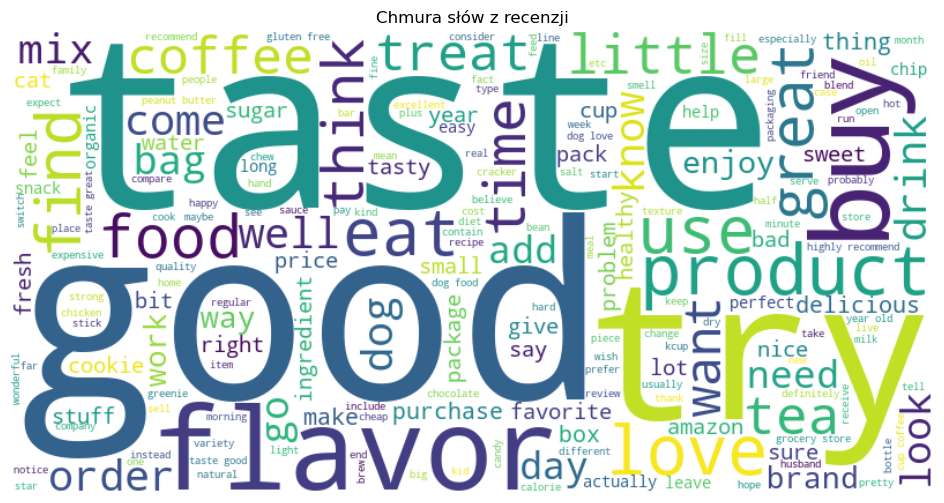

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Połącz tokeny w jeden długi tekst
text_for_cloud = " ".join([" ".join(tokens) for tokens in df['tokens']])

# Stwórz chmurę słów
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_for_cloud)

# Wyświetl
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Chmura słów z recenzji")
plt.show()

## 🔀 Analiza n-gramów (bigramy i trigramy)

W tej sekcji analizujemy najczęściej występujące bigramy (pary słów) oraz trigramy (trójki słów) w przetworzonych recenzjach. Pozwoli nam to lepiej zrozumieć, jakie frazy dominują w zbiorze i czy warto uwzględnić je jako cechy tekstowe.


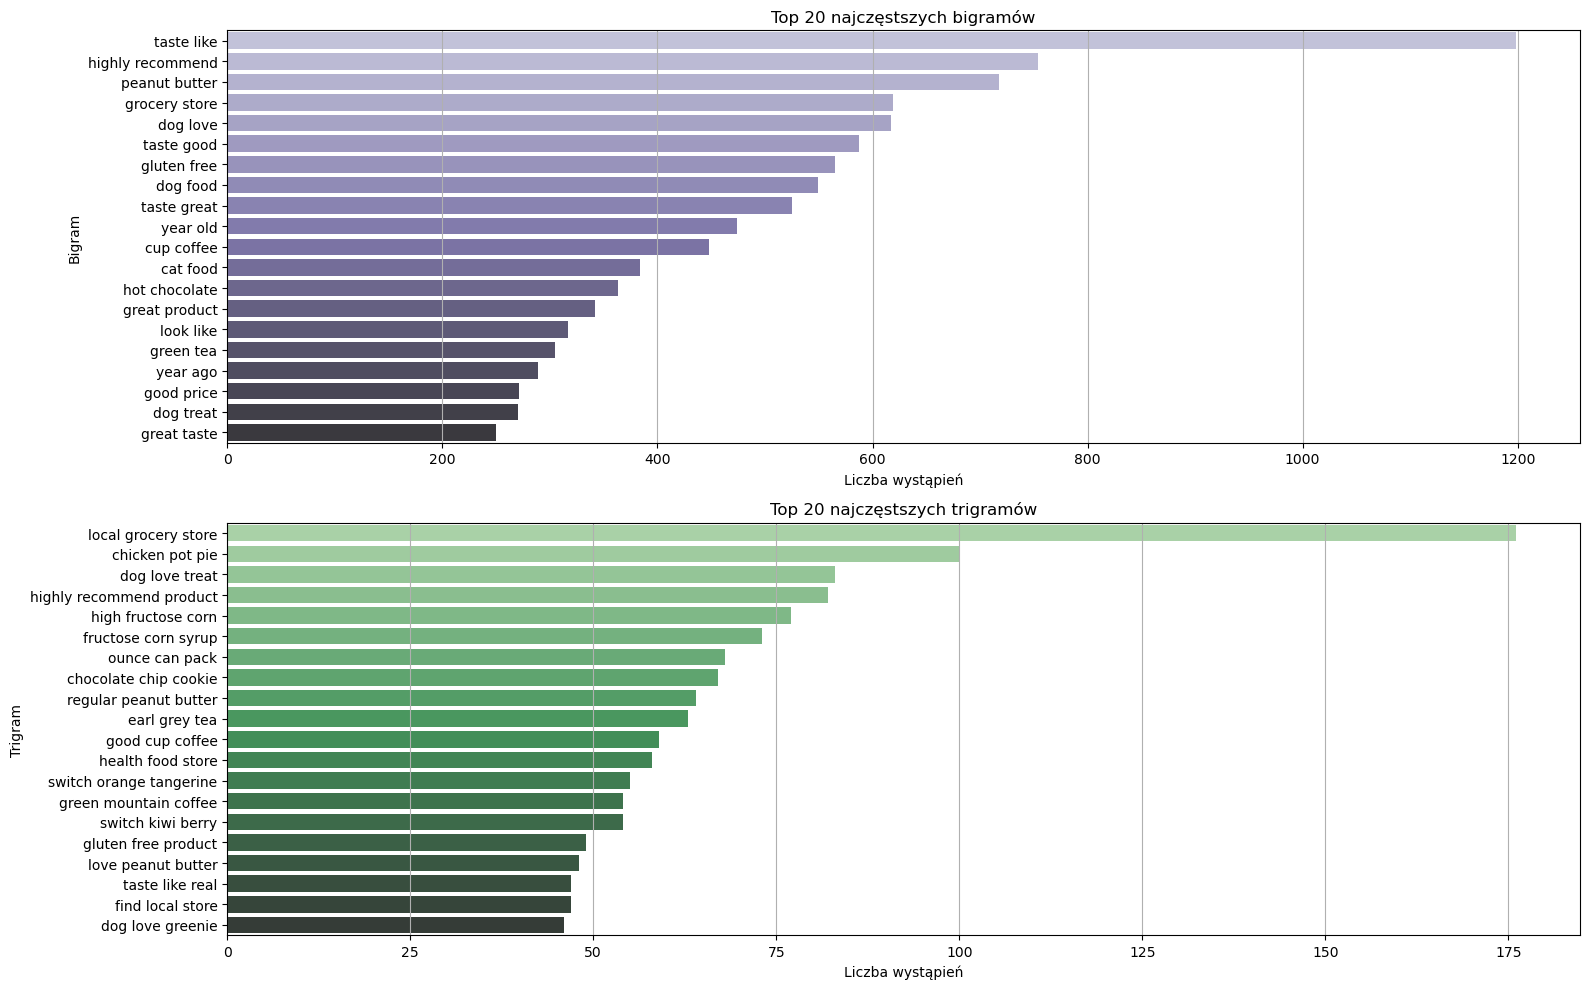

In [26]:
from nltk import ngrams


bigrams = []
trigrams = []

for tokens in df['tokens']:
    bigrams.extend(ngrams(tokens, 2))
    trigrams.extend(ngrams(tokens, 3))


bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)


top_bigrams_df = pd.DataFrame(bigram_counts.most_common(20), columns=['ngram', 'count'])
top_trigrams_df = pd.DataFrame(trigram_counts.most_common(20), columns=['ngram', 'count'])

top_bigrams_df['ngram'] = top_bigrams_df['ngram'].apply(lambda x: ' '.join(x))
top_trigrams_df['ngram'] = top_trigrams_df['ngram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=top_bigrams_df, x='count', y='ngram', hue='ngram', palette='Purples_d', legend=False)
plt.title("Top 20 najczęstszych bigramów")
plt.xlabel("Liczba wystąpień")
plt.ylabel("Bigram")
plt.grid(axis='x')

plt.subplot(2, 1, 2)
sns.barplot(data=top_trigrams_df, x='count', y='ngram', hue='ngram', palette='Greens_d', legend=False)
plt.title("Top 20 najczęstszych trigramów")
plt.xlabel("Liczba wystąpień")
plt.ylabel("Trigram")
plt.grid(axis='x')

plt.tight_layout()
plt.show()

Na podstawie wykresów widzimy, że bigramy takie jak *"highly recommend"*, *"great taste"* czy *"gluten free"* występują bardzo często i niosą znaczącą informację semantyczną. Trigramy również pokazują ciekawe złożone frazy, choć są mniej powszechne. W dalszej analizie uwzględnimy bigramy jako dodatkowe cechy w wektoryzacji tekstu.


### Filtrowanie bardzo krótkich recenzji

W ramach wstępnego oczyszczania danych zdecydowaliśmy się usunąć recenzje zawierające cztery lub mniej słów po przetworzeniu (tj. po lematyzacji i usunięciu stopwords). 

Zakładamy, że recenzje produktów na Amazonie są zawsze powiązane z oceną liczbową (np. w skali od 1 do 5). W związku z tym recenzje wyjątkowo krótkie — np. jedno- do czterowyrazowe komentarze typu „bad”, „very good product” czy „not recommended at all” — nie wnoszą istotnej informacji semantycznej ponad to, co już zawiera liczba gwiazdek. 

Usunięcie tych recenzji pozwala skupić się na danych zawierających treści o wyższej wartości informacyjnej, co jest istotne w kontekście dalszej analizy tematycznej i klasteryzacji.

In [11]:
print(f"Liczba recenzji przed filtrem: {len(df)}")

df=df[df["tokens"].apply(lambda x: len(x)>= 5)].reset_index(drop=True)

df['processed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

print(f"Liczba recenzji po filtrze: {len(df)}")
df[['tokens', 'processed_text']].head()

Liczba recenzji przed filtrem: 21246
Liczba recenzji po filtrze: 21219


,tokens,processed_text
0,"[buy, vitality, can, dog, food, product, find,...",buy vitality can dog food product find good qu...
1,"[product, arrived, label, jumbo, salt, peanuts...",product arrived label jumbo salt peanutsthe pe...
2,"[confection, century, light, pillowy, citrus, ...",confection century light pillowy citrus gelati...
3,"[look, secret, ingredient, robitussin, believe...",look secret ingredient robitussin believe find...
4,"[great, taffy, great, price, wide, assortment,...",great taffy great price wide assortment yummy ...


### Analiza sentymentu za pomocą VADER

Do oceny emocjonalnego wydźwięku recenzji wykorzystujemy narzędzie VADER (Valence Aware Dictionary and sEntiment Reasoner), które jest dostosowane do analizy krótkich tekstów, takich jak opinie internetowe. 

VADER uwzględnia m.in. wielkie litery, wykrzykniki, słowa nacechowane emocjonalnie i potrafi wychwytywać subtelności sentymentu. Dla każdej recenzji wyznaczamy:
- **compound** – ogólny poziom sentymentu (w skali od –1 do 1),
- **pos / neu / neg** – udział pozytywnych, neutralnych i negatywnych słów.

Analiza ta pozwoli nam później lepiej zrozumieć strukturę emocjonalną recenzji oraz potencjalne różnice między klastrami.


In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series({
        'vader_compound': scores['compound'],
        'vader_pos': scores['pos'],
        'vader_neu': scores['neu'],
        'vader_neg': scores['neg']
    })

df_vader = df['Text'].apply(get_vader_sentiment)
df = pd.concat([df, df_vader], axis=1)


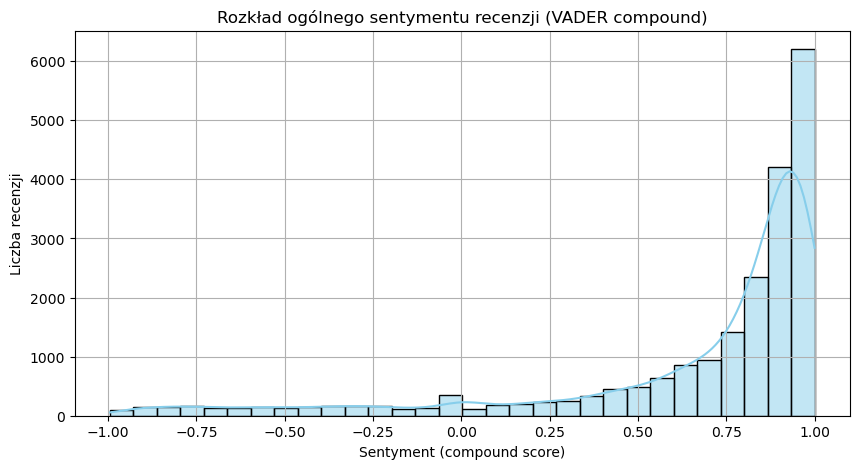

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['vader_compound'], bins=30, kde=True, color='skyblue')

plt.title("Rozkład ogólnego sentymentu recenzji (VADER compound)")
plt.xlabel("Sentyment (compound score)")
plt.ylabel("Liczba recenzji")
plt.grid(True)
plt.show()


### Wniosek z analizy sentymentu

Rozkład wartości `compound` uzyskanych z analizatora VADER pokazuje wyraźną dominację recenzji o pozytywnym wydźwięku. Większość opinii skupia się w przedziale bliskim wartości 1.0, co oznacza, że użytkownicy Amazona najczęściej wystawiają recenzje nacechowane pozytywnie.


In [14]:
df.columns

Index(['Text', 'length', 'clean_text', 'lang', 'tokens', 'num_tokens',
       'processed_text', 'vader_compound', 'vader_pos', 'vader_neu',
       'vader_neg'],
      dtype='object')

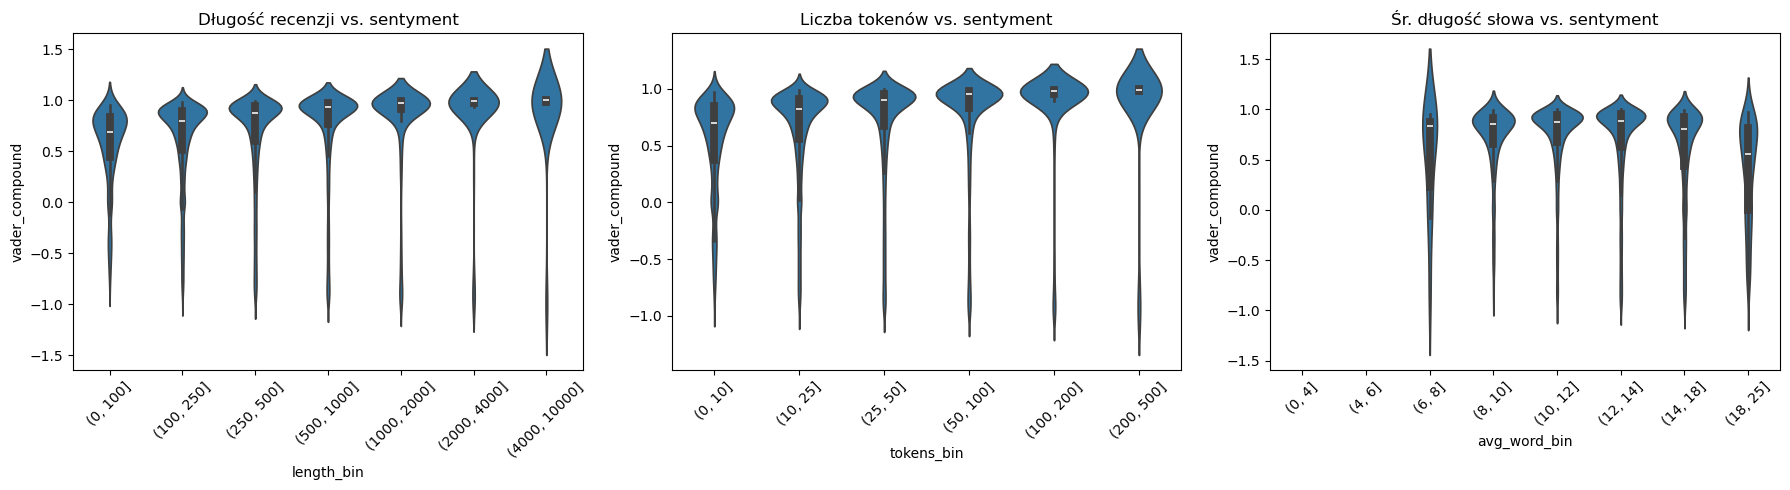

In [15]:
df['avg_word_length'] = df['length'] / df['num_tokens']

# Dodaj binned kolumny
df['length_bin'] = pd.cut(df['length'], bins=[0, 100, 250, 500, 1000, 2000, 4000, 10000])
df['tokens_bin'] = pd.cut(df['num_tokens'], bins=[0, 10, 25, 50, 100, 200, 500])
df['avg_word_bin'] = pd.cut(df['avg_word_length'], bins=[0, 4, 6, 8, 10, 12, 14, 18, 25])

# Rysujemy boxploty
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.violinplot(data=df, x='length_bin', y='vader_compound')
plt.xticks(rotation=45)
plt.title("Długość recenzji vs. sentyment")

plt.subplot(1, 3, 2)
sns.violinplot(data=df, x='tokens_bin', y='vader_compound')
plt.xticks(rotation=45)
plt.title("Liczba tokenów vs. sentyment")

plt.subplot(1, 3, 3)
sns.violinplot(data=df, x='avg_word_bin', y='vader_compound')
plt.xticks(rotation=45)
plt.title("Śr. długość słowa vs. sentyment")

plt.tight_layout()
plt.show()

### Wektoryzacja tekstu za pomocą TF-IDF

Aby umożliwić modelom uczenie się na podstawie tekstu, musimy przekształcić dane tekstowe w reprezentację numeryczną. W tym celu stosujemy metodę TF-IDF (Term Frequency–Inverse Document Frequency), która przypisuje wagę każdemu słowu na podstawie jego częstotliwości w danej recenzji oraz rzadkości w całym zbiorze.

TF-IDF zwraca macierz, w której:
- każdy wiersz odpowiada jednej recenzji,
- każda kolumna odpowiada jednemu słowu (cecha),
- wartości to wagi (liczby) reprezentujące istotność danego słowa w konkretnej recenzji.

Wysoka wartość oznacza, że dane słowo pojawia się w recenzji, ale rzadko występuje w pozostałych tekstach – czyli może być kluczowe dla jej treści. Większość wartości to 0, ponieważ każde wystąpienie słowa kodowane jest tylko tam, gdzie ono faktycznie występuje.


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer_unigram = TfidfVectorizer(ngram_range=(1, 1), max_features=5000)
X_tfidf_unigram = vectorizer_unigram.fit_transform(df["processed_text"])
tfidf_unigram_df = pd.DataFrame(X_tfidf_unigram.toarray(), columns=vectorizer_unigram.get_feature_names_out())

vectorizer_bigram = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_tfidf_bigram = vectorizer_bigram.fit_transform(df["processed_text"])
tfidf_bigram_df = pd.DataFrame(X_tfidf_bigram.toarray(), columns=vectorizer_bigram.get_feature_names_out())

print(f"Unigramy TF-IDF: {X_tfidf_unigram.shape}")
print(f"Bigramy TF-IDF: {X_tfidf_bigram.shape}")

print("Top cechy z unigramów:")
print(tfidf_unigram_df.iloc[0].sort_values(ascending=False).head(5))

print("\nTop cechy z bigramów:")
print(tfidf_bigram_df.iloc[0].sort_values(ascending=False).head(5))

Unigramy TF-IDF: (21219, 5000)
Bigramy TF-IDF: (21219, 5000)
Top cechy z unigramów:
labrador    0.387302
product     0.357375
stew        0.332727
finicky     0.304824
well        0.290414
Name: 0, dtype: float64

Top cechy z bigramów:
product         0.276797
product well    0.271323
stew            0.257707
product find    0.255504
food product    0.254798
Name: 0, dtype: float64


### Dobór liczby komponentów PCA na podstawie wariancji skumulowanej

Macierz TF-IDF ma bardzo wysoką liczbę wymiarów (tysiące kolumn), co może prowadzić do nadmiarowości i dużego kosztu obliczeniowego. W celu redukcji wymiarowości stosujemy PCA (Principal Component Analysis).

Poniższy wykres przedstawia skumulowaną wariancję wyjaśnianą w funkcji liczby komponentów PCA. Dzięki temu możemy określić, ile komponentów jest potrzebnych, aby zachować np. 90% informacji z oryginalnych danych. Wybranie tej liczby komponentów pozwala nam uprościć dane przy minimalnej utracie istotnych cech.


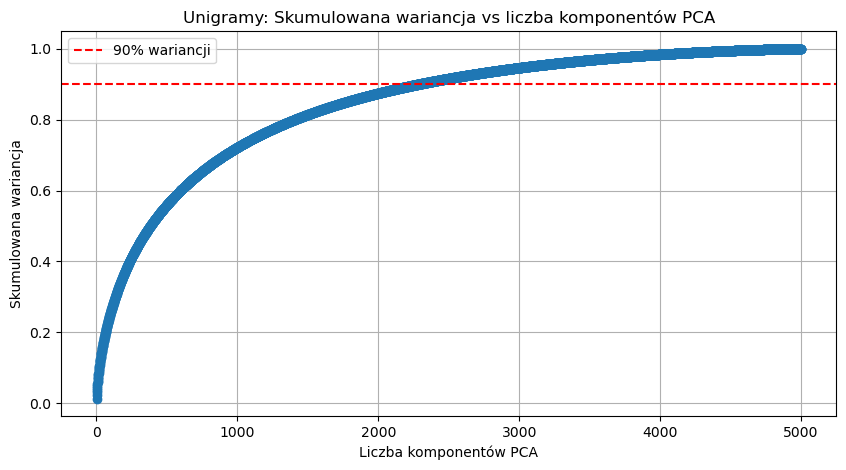

[Unigramy] Liczba komponentów do 90% wariancji: 2287


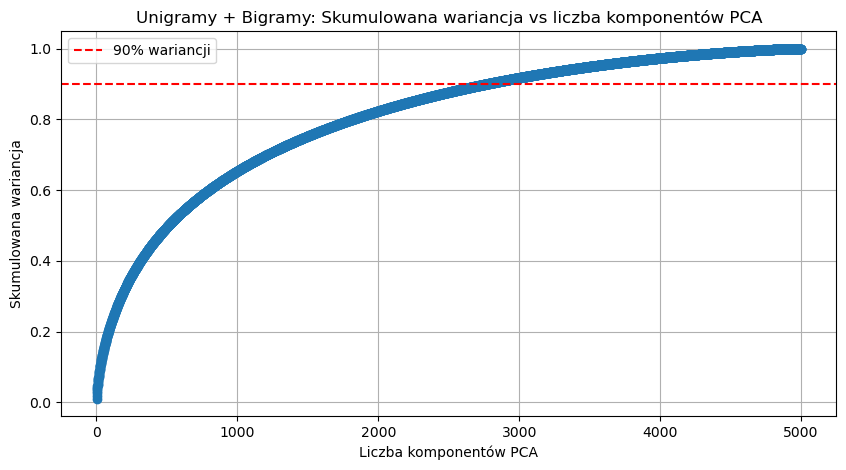

[Bigramy] Liczba komponentów do 90% wariancji: 2765


In [32]:
from sklearn.decomposition import PCA

# PCA na unigramach
pca_unigram = PCA()
X_pca_unigram = pca_unigram.fit_transform(X_tfidf_unigram.toarray())
explained_var_uni = np.cumsum(pca_unigram.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var_uni) + 1), explained_var_uni, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% wariancji')
plt.title("Unigramy: Skumulowana wariancja vs liczba komponentów PCA")
plt.xlabel("Liczba komponentów PCA")
plt.ylabel("Skumulowana wariancja")
plt.grid(True)
plt.legend()
plt.show()

n_components_unigram = np.argmax(explained_var_uni >= 0.90) + 1
print(f"[Unigramy] Liczba komponentów do 90% wariancji: {n_components_unigram}")

# PCA na bigramach
pca_bigram = PCA()
X_pca_bigram = pca_bigram.fit_transform(X_tfidf_bigram.toarray())
explained_var_bigram = np.cumsum(pca_bigram.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var_bigram) + 1), explained_var_bigram, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% wariancji')
plt.title("Unigramy + Bigramy: Skumulowana wariancja vs liczba komponentów PCA")
plt.xlabel("Liczba komponentów PCA")
plt.ylabel("Skumulowana wariancja")
plt.grid(True)
plt.legend()
plt.show()

n_components_bigram = np.argmax(explained_var_bigram >= 0.90) + 1
print(f"[Bigramy] Liczba komponentów do 90% wariancji: {n_components_bigram}")

Dodanie bigramów znacząco zwiększyło liczbę cech potrzebnych do wyjaśnienia 90% wariancji (z 2287 do 2765), co wskazuje na większe rozproszenie informacji w danych. Choć może to pogorszyć wydajność i zwiększyć złożoność modelu, bigramy mogą wprowadzać dodatkową wartość semantyczną. Decyzję o ich wykorzystaniu należy oprzeć na ocenie jakości klasteryzacji.


In [33]:
pca = PCA(n_components=n_components_unigram)
X_pca = pca.fit_transform(X_tfidf.toarray())

In [34]:
pca = PCA(n_components=n_components_bigram)
X_pca_bigram = pca.fit_transform(X_tfidf.toarray())

In [35]:
df.to_csv("amazon_reviews_processed.csv", index=False)
np.save("X_pca.npy", X_pca)
np.save("X_pca_bigram.npy", X_pca_bigram)

## 🤖 Embeddingi z Sentence-BERT

W tej części testujemy alternatywne podejście do reprezentacji tekstu — zamiast klasycznego TF-IDF, używamy nowoczesnego modelu typu Sentence-BERT, który tworzy gęste embeddingi dla całych recenzji. Modele tego typu uwzględniają znaczenie i kontekst słów w zdaniu, co pozwala lepiej oddać semantykę tekstu.

Embeddingi zostaną utworzone na podstawie przetworzonych recenzji (`processed_text`), a następnie wykorzystane do klasteryzacji. Na końcu porównamy jakość klastrów uzyskanych przez obie metody — TF-IDF oraz Sentence-BERT.


In [20]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

texts = df["processed_text"].astype(str).tolist()

X_sbert = model.encode(texts, show_progress_bar=True)

print("Rozmiar embeddingów SBERT:", X_sbert.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\Mateu\anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mateu\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/664 [00:00<?, ?it/s]

Rozmiar embeddingów SBERT: (21219, 384)


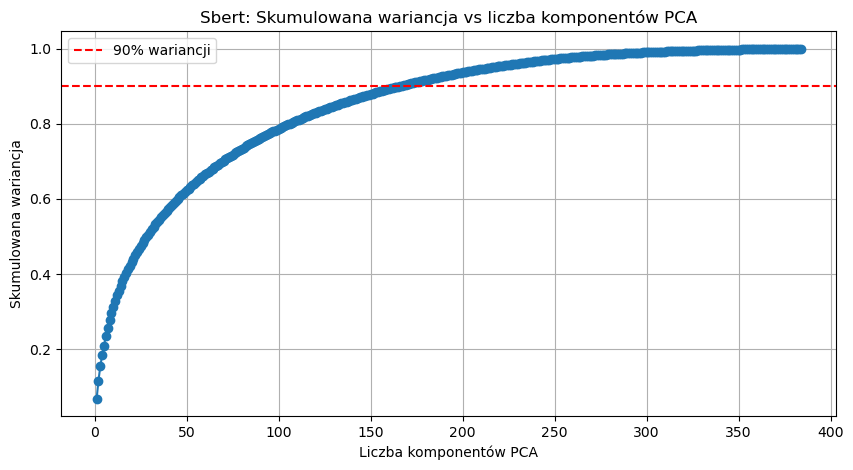

[Sbert] Liczba komponentów do 90% wariancji: 166


In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_sbert=PCA()

X_pca_sbert = pca_sbert.fit_transform(X_sbert)
explained_var_sbert = np.cumsum(pca_sbert.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var_sbert) + 1), explained_var_sbert, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% wariancji')
plt.title("Sbert: Skumulowana wariancja vs liczba komponentów PCA")
plt.xlabel("Liczba komponentów PCA")
plt.ylabel("Skumulowana wariancja")
plt.grid(True)
plt.legend()
plt.show()

n_components_sbert = np.argmax(explained_var_sbert >= 0.90) + 1
print(f"[Sbert] Liczba komponentów do 90% wariancji: {n_components_sbert}")

In [5]:
pca = PCA(n_components=n_components_sbert)
X_pca_sbert = pca.fit_transform(X_sbert)

In [6]:
X_pca_sbert.shape

(21219, 166)

### 🧠 Redukcja wymiarów embeddingów SBERT za pomocą PCA

🔍 **Wniosek:**  
Embeddingi SBERT są znacznie bardziej informacyjne i skondensowane niż reprezentacje oparte na TF-IDF, które dla tej samej granicy wariancji wymagały nawet **ponad 2700 cech** (w przypadku TF-IDF z bigramami). Oznacza to, że:

- podejście embeddingowe lepiej uchwytuje znaczenie semantyczne recenzji,
- znacznie lepiej nadaje się do dalszych metod, takich jak klasteryzacja.

➡️ W kolejnych krokach będziemy **równolegle testować podejście z embeddingami SBERT oraz TF-IDF**, aby porównać, które z nich zapewnia **lepszą separację klastrów**. To pozwoli nam obiektywnie ocenić skuteczność obu reprezentacji w zadaniu klasteryzacji.


In [28]:
file_name = "X_sbert.npy"
full_path = os.path.join(sciezka_robocza, file_name)

# Zapis macierzy do pliku .npy
np.save(full_path, X_sbert)

In [1]:
sciezka_robocza="C:/Users/Mateu/OneDrive/Dokumenty/dane_do_amazona"
file_name = "X_sbert.npy"

import os 
import numpy as np
import pandas as pd

df=pd.read_csv(os.path.join(sciezka_robocza,"amazon_reviews_processed.csv"))
X_pca=np.load(os.path.join(sciezka_robocza,"X_pca.npy"))
X_sbert=np.load(os.path.join(sciezka_robocza,file_name))


## 🔍 Klasteryzacja recenzji

Po uzyskaniu reprezentacji recenzji w postaci embeddingów SBERT przechodzimy do etapu klasteryzacji. Celem tego kroku jest pogrupowanie recenzji w klastry na podstawie ich semantycznego podobieństwa — bez wykorzystania etykiet.

Przetestujemy różne algorytmy klasteryzacji (m.in. KMeans, DBSCAN), porównamy ich jakość (np. przy pomocy silhouette score) oraz przeanalizujemy charakterystyki powstałych klastrów. Pozwoli to określić, czy w zbiorze występują wyraźnie różniące się grupy recenzji.


### 📌 KMeans

Pierwszym podejściem będzie zastosowanie algorytmu KMeans, który dzieli dane na określoną liczbę klastrów na podstawie odległości euklidesowej. Aby dobrać optymalną liczbę klastrów, zastosujemy metodę łokcia oraz silhouette score.

KMeans jest algorytmem szybkim i łatwym do interpretacji, dlatego stanowi dobre pierwsze podejście do eksploracji struktury danych w przestrzeni embeddingów.


### 🔹 Podejście z embeddingami 

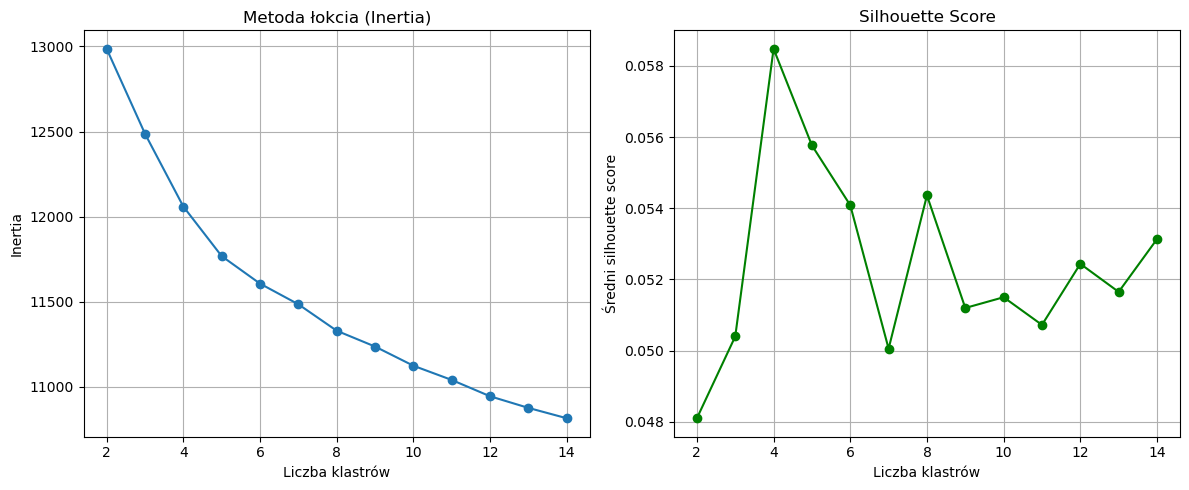

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Zakres liczby klastrów do sprawdzenia
cluster_range = list(range(2, 15))
inertia = []
silhouette_scores = []

# Testowanie różnych liczby klastrów
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca_sbert)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca_sbert, labels))

plt.figure(figsize=(12, 5))

# Wykres łokcia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title("Metoda łokcia (Inertia)")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inertia")
plt.grid(True)

# Wykres silhouette score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Liczba klastrów")
plt.ylabel("Średni silhouette score")
plt.grid(True)

plt.tight_layout()
plt.show()


### 🔹 Podejście z reprezentacją TF-IDF

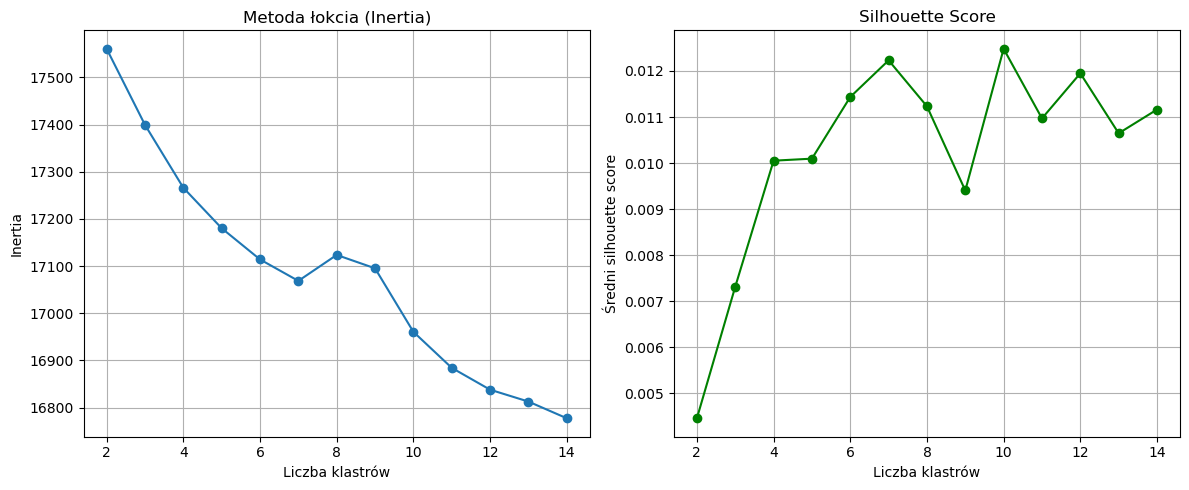

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Zakres liczby klastrów do sprawdzenia
cluster_range = list(range(2, 15))
inertia = []
silhouette_scores = []

# Testowanie różnych liczby klastrów
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

plt.figure(figsize=(12, 5))

# Wykres łokcia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title("Metoda łokcia (Inertia)")
plt.xlabel("Liczba klastrów")
plt.ylabel("Inertia")
plt.grid(True)

# Wykres silhouette score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Liczba klastrów")
plt.ylabel("Średni silhouette score")
plt.grid(True)

plt.tight_layout()
plt.show()


### 📊 Porównanie wyników metody łokcia i silhouette score — TF-IDF vs SBERT

#### 🔍 Wnioski:
- W przypadku **TF-IDF**:
  - Metoda łokcia nie daje jednoznacznego punktu załamania — wykres jest nieregularny, a inercja w okolicy 8 klastrów nawet rośnie, co jest nienaturalne.
  - Średnie silhouette score są bardzo niskie, poniżej 0.013, co oznacza słabą separację klastrów.

- W przypadku **embeddingów SBERT**:
  - Wykres łokcia pokazuje stopniowe wygładzanie inercji, co jest oczekiwanym zachowaniem.
  - Silhouette score są wyższe (ok. 0.058), co świadczy o **lepszej jakości klasteryzacji**.

#### ✅ Decyzja:
Zdecydowaliśmy się kontynuować pracę **wyłącznie na embeddingach SBERT**, ponieważ:
- Lepsza jakość klastrów (silhouette)
- Stabilniejszy przebieg inercji
- Bardziej semantyczna reprezentacja recenzji

---

### 📌 Przechodzimy do właściwej klasteryzacji metodą KMeans na embeddingach SBERT


In [11]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_pca_sbert)

df['cluster_KMeans'] = kmeans.labels_

In [17]:
df['cluster_KMeans'].value_counts().sort_index()

cluster_KMeans
0    4031
1    4920
2    9013
3    3255
Name: count, dtype: int64

In [18]:
df.groupby('cluster_KMeans')[['length', 'vader_compound']].mean()

,length,vader_compound
cluster_KMeans,,
0,414.199454,0.699416
1,335.752642,0.558963
2,460.942971,0.705917
3,531.340092,0.667610


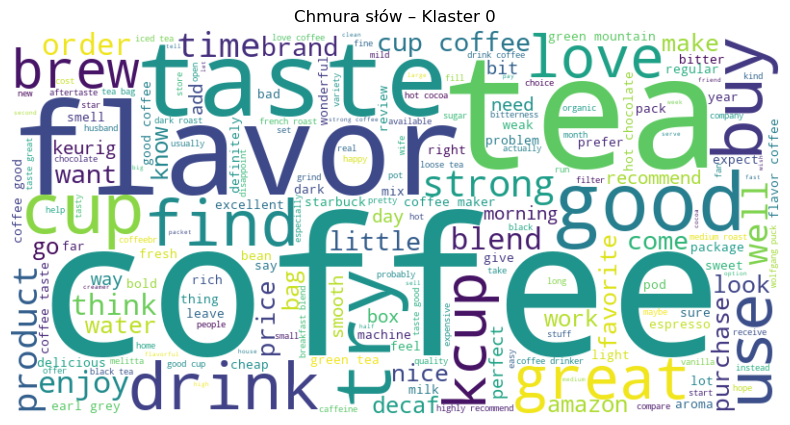

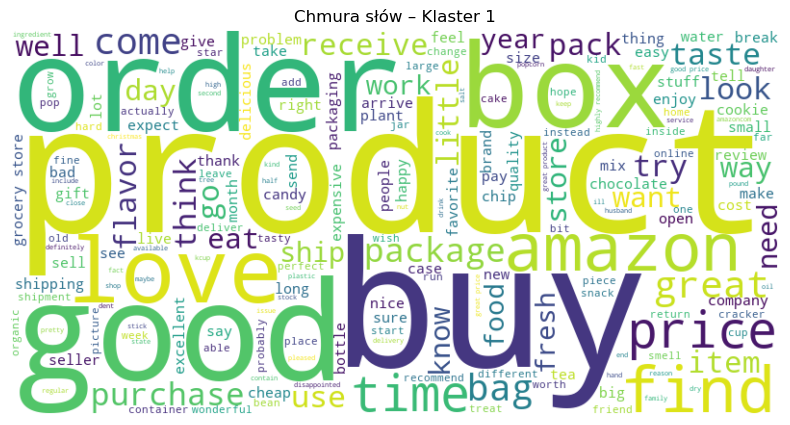

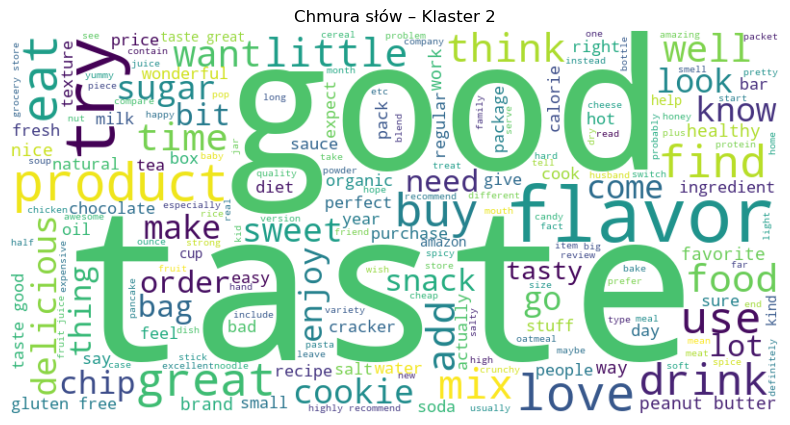

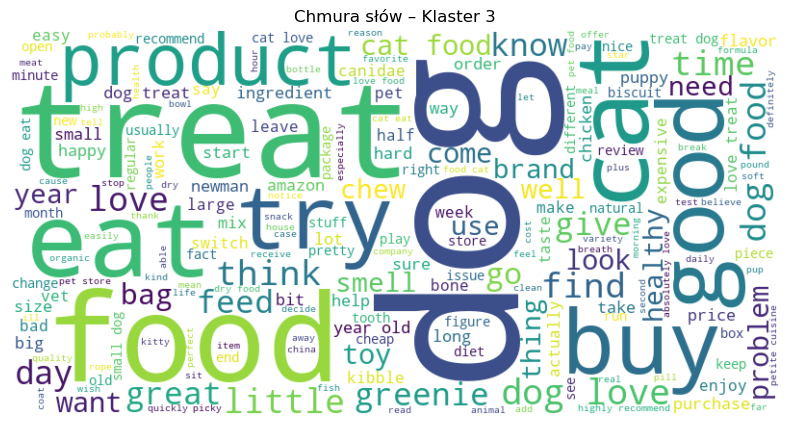

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cluster_id in sorted(df['cluster_KMeans'].unique()):
    text = " ".join(df[df['cluster_KMeans'] == cluster_id]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Chmura słów – Klaster {cluster_id}')
    plt.show()

C:\Users\Mateu\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


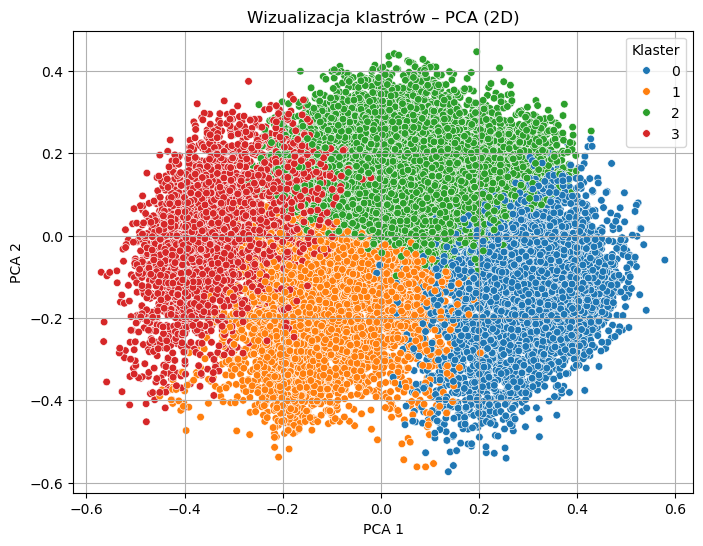

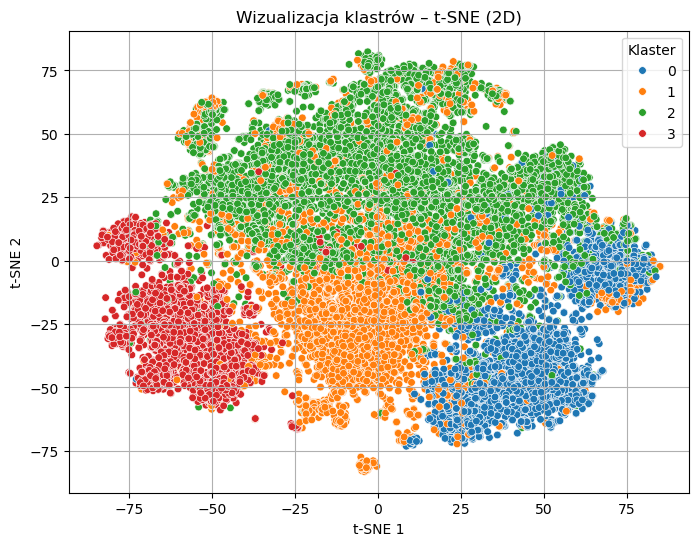

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# PCA 2D
pca_2d = PCA(n_components=2)
X_sbert_pca_2d = pca_2d.fit_transform(X_sbert)

# t-SNE 2D
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_sbert_tsne_2d = tsne_2d.fit_transform(X_sbert)

# Dodajemy do df
df["pca_1"] = X_sbert_pca_2d[:, 0]
df["pca_2"] = X_sbert_pca_2d[:, 1]
df["tsne_1"] = X_sbert_tsne_2d[:, 0]
df["tsne_2"] = X_sbert_tsne_2d[:, 1]

# Wykres PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="cluster_KMeans", palette="tab10", s=30)
plt.title("Wizualizacja klastrów – PCA (2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Klaster")
plt.grid(True)
plt.show()

# Wykres t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="tsne_1", y="tsne_2", hue="cluster_KMeans", palette="tab10", s=30)
plt.title("Wizualizacja klastrów – t-SNE (2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Klaster")
plt.grid(True)
plt.show()

### Podsumowanie klastrów KMeans (SBERT)

**Klaster 0**  
🔹 Średnia długość tekstu: umiarkowana  
🔹 Średni sentyment: wysoki (~0.70)  
🔹 Chmura słów sugeruje tematy związane z napojami: „coffee”, „tea”, „taste”, „flavor”  
🔹 Możliwa grupa: pozytywne opinie o napojach

**Klaster 1**  
🔹 Najkrótsze recenzje  
🔹 Średni sentyment: najniższy (~0.56)  
🔹 Chmura słów zawiera ogólne słowa: „product”, „order”, „package”  
🔹 Możliwa grupa: krótkie i mniej entuzjastyczne recenzje

**Klaster 2**  
🔹 Dłuższe recenzje  
🔹 Najwyższy sentyment (~0.71)  
🔹 Chmura zawiera: „taste”, „sweet”, „cookie”, „delicious”  
🔹 Możliwa grupa: bardzo pozytywne opinie o jedzeniu i słodyczach

**Klaster 3**  
🔹 Najdłuższe recenzje  
🔹 Średni sentyment: umiarkowanie wysoki (~0.67)  
🔹 Dominują słowa: „treat”, „dog”, „cat”, „food”, „buy”  
🔹 Możliwa grupa: recenzje dotyczące karmy i produktów dla zwierząt

In [22]:
import os
import numpy as np

# Ścieżka robocza
sciezka_robocza = "C:/Users/Mateu/OneDrive/Dokumenty/dane_do_amazona"

# Zapisz df jako CSV
df_path = os.path.join(sciezka_robocza, "df_clasters.csv")
df.to_csv(df_path, index=False)

# Zapisz macierz X_pca_sbert jako .npy
pca_path = os.path.join(sciezka_robocza, "X_pca_sbert.npy")
np.save(pca_path, X_pca_sbert)